<h1><center><font size="25">Predicción (<i>forecasting</i>) de la demanda eléctrica con Python</font></center></h1>

<center><b>Joaquín Amat Rodrigo</b></center>

<center><i>Abril, 2021 (última actualización Marzo 2022) </i></center>

Más sobre ciencia de datos: [**cienciadedatos.net**](https://cienciadedatos.net)

+ [Forecasting series temporales con Python y Scikit Learn](https://www.cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html)
+ [Predicción (forecasting) de visitas a página web con machine learning](https://www.cienciadedatos.net/documentos/py37-forecasting-visitas-web-machine-learning.html)
+ [Forecasting series temporales con gradient boosting: Skforecast, XGBoost, LightGBM y CatBoost](https://www.cienciadedatos.net/documentos/py39-forecasting-series-temporales-con-skforecast-xgboost-lightgbm-catboost.html)
+ [Predicción del precio de Bitcoin con Python](https://www.cienciadedatos.net/documentos/py41-forecasting-criptomoneda-bitcoin-machine-learning-python.html)

## Introducción
<br>

Una [serie temporal](https://es.wikipedia.org/wiki/Serie_temporal) (*time series*) es una sucesión de datos ordenados cronológicamente, espaciados a intervalos iguales o desiguales. El proceso de [*forecasting*](https://en.wikipedia.org/wiki/Forecasting) consiste en predecir el valor futuro de una serie temporal, bien modelando la serie únicamente en función de su comportamiento pasado (autorregresivo) o empleando otras variables externas.

<div>
<img src='./images/forecasting_multi-step.gif' width="600"/>
</div>

<br>

Cuando se trabaja con series temporales, raramente se quiere predecir solo el siguiente elemento de la serie ($t_{+1}$), sino todo un intervalo futuro ($t_{+1}$), ..., ($t_{+n}$)) o un punto alejado en el tiempo ($t_{+n}$).  Existen varias estrategias que permiten generar este tipo de predicciones múltiples, la librería **skforecast** recoge las siguientes:

+ [**Recursive multi-step forecasting**](https://www.cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html#Recursive-multi-step-forecasting): dado que, para predecir el momento $t_{n}$ se necesita el valor de $t_{n-1}$, y $t_{n-1}$ se desconoce, se sigue un proceso recursivo en el que, cada nueva predicción, hace uso de la predicción anterior.

+ [**Direct multi-step forecasting**](https://www.cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html#Direct-multi-step-forecasting): consiste en entrenar un modelo distinto para cada valor futuro (*step*) que se quiere predecir. 

En este documento se muestra un ejemplo de cómo utilizar métodos de forecasting para predecir la demanda eléctrica a nivel horario. En concreto, se hace uso de [**skforecast**](https://joaquinamatrodrigo.github.io/skforecast/latest/index.html), una librería que contiene las clases y funciones necesarias para adaptar cualquier modelo de regresión de **scikit-learn** a problemas de *forecasting*.

Para casos de uso más detallados visitar [skforecast-examples](https://joaquinamatrodrigo.github.io/skforecast/latest/examples/examples.html).
<br><br>

## Caso de uso
<br>

Se dispone de una serie temporal con la demanda eléctrica (MW) del estado de Victoria (Australia) desde 2011-12-31 al 2014-12-31. Se pretende generar un modelo de *forecasting* capaz de predecir la demanda energética del día siguiente a nivel horario. 
<br>

## Librerías
<br>

Las librerías utilizadas en este documento son:

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Datos
<br>

Los datos empleados en este documento se han obtenido del paquete de **R** [tsibbledata]("https://tsibbledata.tidyverts.org/"). El set de datos contiene 5 columnas y 52608 registros completos. La información de cada columna es:

+ Time: fecha y hora del registro.

+ Date: fecha del registro

+ Demand: demanda de electricidad MW.

+ Temperature: temperatura en Melbourne, capital del estado de Victoria.

+ Holiday: indicador si el día es festivo (vacaciones).

In [2]:
# Descarga de datos
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
datos = pd.read_csv(url, sep=',')
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


La columna *Time* se ha almacenado como `string`. Para convertirla en `datetime`, se emplea la función `pd.to_datetime()`. Una vez en formato `datetime`, y para hacer uso de las funcionalidades de **pandas**, se establece como índice. Además, dado que los datos se han registrado cada 30 minutos, se indica la frecuencia ('30min').

In [3]:
# Conversión del formato fecha
# ==============================================================================
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos = datos.set_index('Time')
datos = datos.asfreq('30min')
datos = datos.sort_index()

Uno de los primeros análisis que hay que realizar al trabajar con series temporales es verificar si la serie está completa.

In [4]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

True

In [5]:
# Completar huecos en un índice temporal
# ==============================================================================
# datos.asfreq(freq='30min', fill_value=np.nan)

Aunque los datos se encuentran en intervalos de 30 minutos, el objetivo es crear un modelo capaz de predecir la demanda eléctrica a nivel horario, por lo que se tienen que agregar los datos. Este tipo de transformación es muy sencillas si se combina el índice de tipo temporal de pandas y su método `resample()`. 

Es muy importante utilizar correctamente los argumentos `closed='left'` y `label='right'` para no introducir en el entrenamiento información a futuro ([*leakage*](https://en.wikipedia.org/wiki/Leakage_(machine_learning))). Supóngase que se dispone de valores para las 10:10, 10:30, 10:45, 11:00, 11:12 y 11:30. Si se quiere obtener el promedio horario, el valor asignado a las 11:00 debe calcularse utilizando los valores de las 10:10, 10:30 y 10:45; y el de las 12:00, con el valor de las 11:00, 11:12 y 11:30.

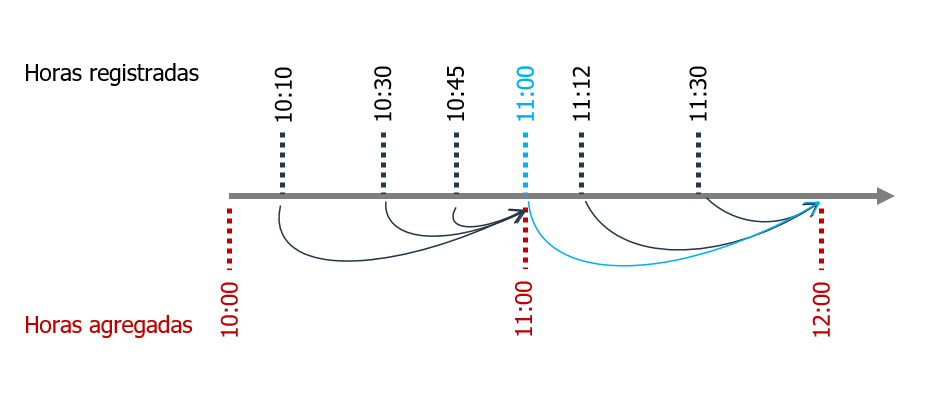

In [6]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = "images/diagrama_resampling_datetime.PNG", width=600)

In [7]:
from IPython.core.display import HTML
HTML("<center><font size='2.5'> <i>" +
"Diagrama de agregado de datos temporales sin incluir información de futuro." +
     "</i></font></center>")

Para el valor promedio de las 11:00 no se incluye el valor puntual de las 11:00 por que, en la realidad, en ese momento exacto no se dispone todavía del valor.

In [8]:
# Agregado en intervalos de 1H
# ==============================================================================
# Se elimina la columna Date para que no genere error al agregar. La columna Holiday
# no genera error ya que es booleana y se trata como 0-1.
datos = datos.drop(columns='Date')
datos = datos.resample(rule='H', closed='left', label ='right').mean()
datos

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0
...,...,...,...
2014-12-31 09:00:00,4069.625550,21.600,0.0
2014-12-31 10:00:00,3909.230704,20.300,0.0
2014-12-31 11:00:00,3900.600901,19.650,0.0


El set de datos empieza el *2011-12-31 14:00:00* y termina el *2014-12-31 13:00:00*. Se descartan los primeros 10 y los últimos 13 registros para que empiece el *2012-01-01 00:00:00* y termine el *2014-12-30 23:00:00*. Además, para poder optimizar los hiperparámetros del modelo y evaluar su  capacidad predictiva, se dividen los datos en 3 conjuntos, uno de entrenamiento, uno de validación y otro de test.

In [9]:
# Separación datos train-val-test
# ==============================================================================
datos = datos.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
fin_train = '2013-12-31 23:59:00'
fin_validacion = '2014-11-30 23:59:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2012-01-01 00:00:00 --- 2013-12-31 23:00:00  (n=17544)
Fechas validacion : 2014-01-01 00:00:00 --- 2014-11-30 23:00:00  (n=8016)
Fechas test       : 2014-12-01 00:00:00 --- 2014-12-30 23:00:00  (n=720)


## Exploración gráfica
<br>

Cuando se quiere generar un modelo de *forecasting*, es importante representar los valores de la serie temporal. Esto permite identificar patrones tales como tendencias y estacionalidad.

**Serie temporal completa**

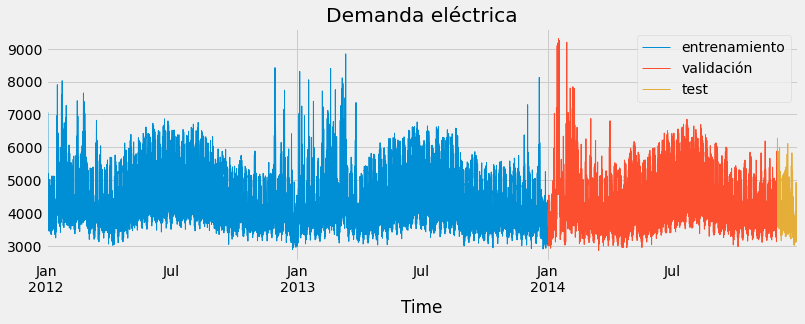

In [10]:
# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
datos_train.Demand.plot(ax=ax, label='entrenamiento', linewidth=1)
datos_val.Demand.plot(ax=ax, label='validación', linewidth=1)
datos_test.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Demanda eléctrica')
ax.legend();

El gráfico anterior muestra que la demanda eléctrica tiene estacionalidad anual.  Se observa un incremento centrado en el mes de Julio y picos de demanda muy acentuados entre enero y marzo.
<br><br>

**Sección de la serie temporal**

Debido a la varianza de la serie temporal, no es posible apreciar con un solo gráfico el posible patrón intradiario.

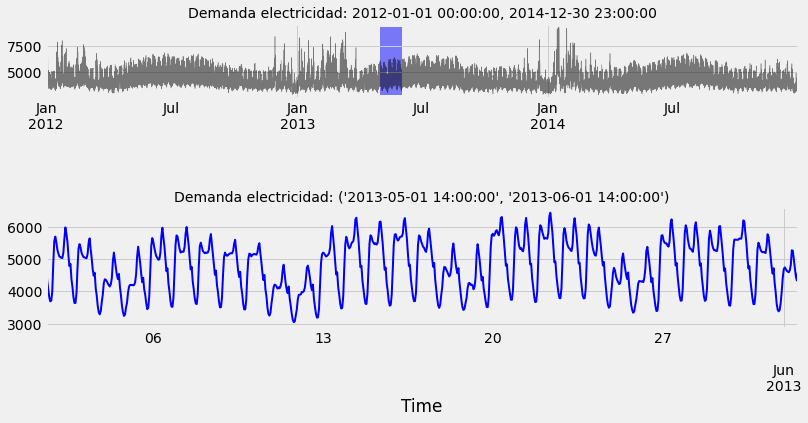

In [11]:
# Gráfico serie temporal con zoom
# ==============================================================================
zoom = ('2013-05-01 14:00:00','2013-06-01 14:00:00')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

datos.Demand.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(datos.Demand)
max_y = max(datos.Demand)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

datos.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Demanda electricidad: {datos.index.min()}, {datos.index.max()}', fontsize=14)
zoom_ax.set_title(f'Demanda electricidad: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

Al aplicar zoom sobre la serie temporal, se hace patente una clara estacionalidad semanal, con consumos más elevados durante la semana laboral (lunes a viernes) y menor en los fines de semana. Se observa también que existe una clara correlación entre el consumo de un día con el del día anterior.
<br><br>


**Estacionalidad anual, semanal y diaria**

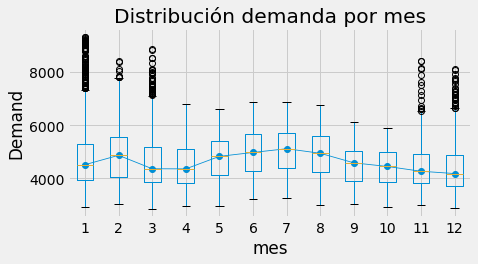

In [12]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['mes'] = datos.index.month
datos.boxplot(column='Demand', by='mes', ax=ax,)
datos.groupby('mes')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

Se observa que hay una estacionalidad anual, con valores de demanda (mediana) superiores en los meses de Junio, Julio y Agosto, y con elevados picos de demanda en los meses de Noviembre, Diciembre, Enero, Febrero y Marzo.

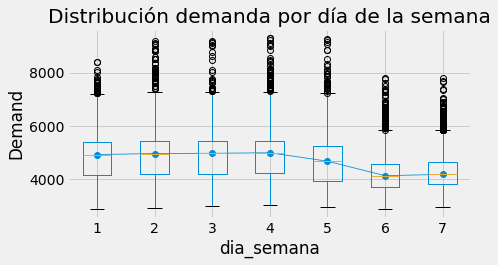

In [13]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['dia_semana'] = datos.index.day_of_week + 1
datos.boxplot(column='Demand', by='dia_semana', ax=ax)
datos.groupby('dia_semana')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por día de la semana')
fig.suptitle('');

Se aprecia una estacionalidad semanal, con valores de demanda inferiores durante el fin de semana.
<br><br>

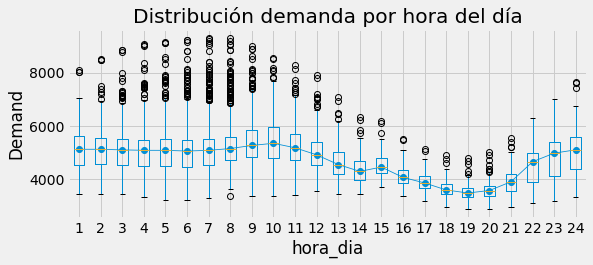

In [14]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
datos['hora_dia'] = datos.index.hour + 1
datos.boxplot(column='Demand', by='hora_dia', ax=ax)
datos.groupby('hora_dia')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por hora del día')
fig.suptitle('');

También existe una estacionalidad diaria, la demanda se reduce entre las 16 y las 21 horas.
<br><br>

**Días festivos y no festivos**

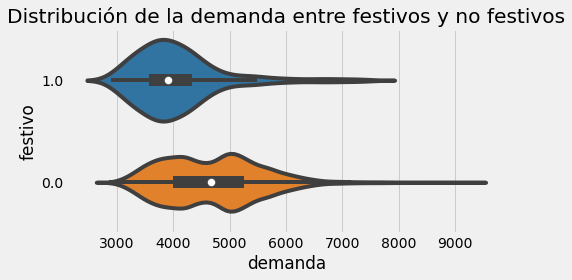

In [15]:
# Grafico violinplot
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.violinplot(
    x       = 'Demand',
    y       = 'Holiday',
    data    = datos.assign(Holiday = datos.Holiday.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de la demanda entre festivos y no festivos')
ax.set_xlabel('demanda')
ax.set_ylabel('festivo');

Los días festivos tienden a tener menor consumo.
<br><br>

**Gráficos de autocorrelación**

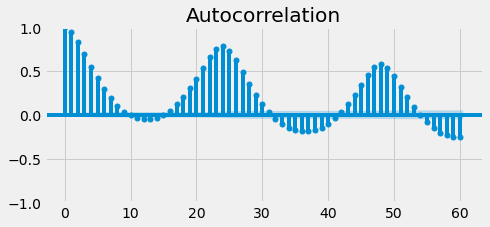

In [16]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(datos.Demand, ax=ax, lags=60)
plt.show()

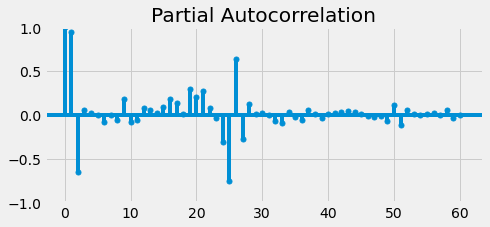

In [17]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(datos.Demand, ax=ax, lags=60)
plt.show()

Los gráficos de autocorrelación y autocorrelación parcial muestran una clara asociación entre la demanda de una hora y las horas anteriores, así como entre la demanda de una hora y la demanda de esa misma hora los días anteriores. Este tipo de correlación, es un indicativo de que los modelos autorregresivos pueden funcionar bien.
<br><br>

## Modelo autoregresivo recursivo
<br>

Se crea y entrena un modelo autorregresivo recursivo (`ForecasterAutoreg`) a partir de un modelo de [regresión lineal con penalización Ridge](https://www.cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python.html) y una ventana temporal de 24 lags. Esto último significa que, para cada predicción, se utilizan como predictores la demanda de las 24 horas anteriores.

### Entrenamiento del Forecaster

In [18]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge()),
                lags      = 24
             )

forecaster.fit(y=datos.loc[:fin_validacion, 'Demand'])
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-04-03 22:09:57 
Last fit date: 2022-04-03 22:09:57 
Skforecast version: 0.4.3 

### Predicción (*backtest*)
<br>

Se evalúa el comportamiento que habría tenido el modelo si se hubiese entrenado con los datos desde 2012-01-01 00:00 al 2014-11-30 23:59 y, después, a las 23:59 de cada día, se predijesen las 24 horas siguientes. A este tipo de evaluación se le conoce como [*backtesting*](file:///home/ximo/Documents/GitHub/cienciadedatos.net/documentos/py37-forecasting-visitas-web-machine-learning-0.4.html#Caso-de-uso), y puede aplicarse fácilmente con la función `backtesting_forecaster()`. Esta función devuelve, además de las predicciones, una métrica de error.

In [19]:
# Backtest
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos.Demand,
                            initial_train_size = len(datos.loc[:fin_validacion]),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 25560
Number of observations used for backtesting: 720
    Number of folds: 30
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00
    Validation: 2014-12-01 00:00:00 -- 2014-12-01 23:00:00
Data partition in fold: 1
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00
    Validation: 2014-12-02 00:00:00 -- 2014-12-02 23:00:00
Data partition in fold: 2
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00
    Validation: 2014-12-03 00:00:00 -- 2014-12-03 23:00:00
Data partition in fold: 3
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00
    Validation: 2014-12-04 00:00:00 -- 2014-12-04 23:00:00
Data partition in fold: 4
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00
    Validation: 2014-12-05 00:00:00 -- 2014-12-05 23:00:00
Data partition in fold: 5


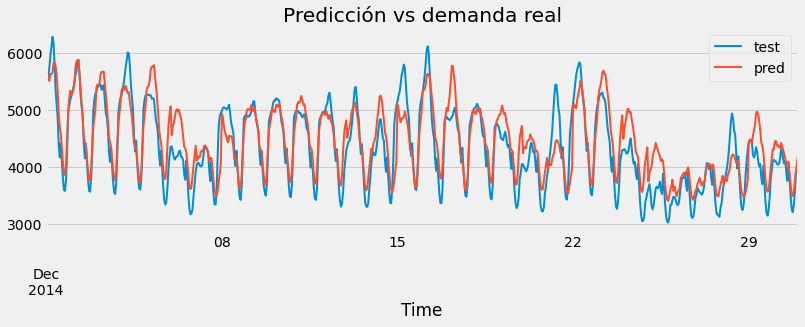

In [20]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(ax=ax, linewidth=2, label='test')
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [21]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

Error backtest: 289.51915030381366


### Optimización de hiperparámetros (*tuning*)
<br>

En el objeto `ForecasterAutoreg` entrenado, se han utilizado los primeros 24 lags y un modelo [Ridge](https://www.cienciadedatos.net/documentos/py08_random_forest_python.html) con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados.

Con el objetivo de identificar la mejor combinación de lags e hiperparámetros, se recurre a un *Grid Search*. Este proceso consiste en entrenar un modelo con cada combinación de hiperparámetros y lags, y evaluar su capacidad predictiva mediante *backtesting*. En el proceso de búsqueda, es importante evaluar los modelos utilizando únicamente los datos de validación y no incluir los de test, estos se utilizan solo en último lugar para evaluar al modelo final.

In [22]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = make_pipeline(StandardScaler(), Ridge()),
                    lags      = 24 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Hiperparámetros del regresor
param_grid = {'ridge__alpha': np.logspace(-3, 5, 10)}

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos.loc[:fin_validacion, 'Demand'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 24,
                        metric      = 'mean_absolute_error',
                        refit       = False,
                        initial_train_size = len(datos[:fin_train]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
                  )

Number of models compared: 30


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:40<00:00, 13.34s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'ridge__alpha': 215.44346900318823}
  Backtesting metric: 257.84317250567267



In [23]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,metric,ridge__alpha
26,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 215.44346900318823},257.843173,215.443469
25,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 27.825594022071257},290.555205,27.825594
24,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 3.593813663804626},306.631981,3.593814
23,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 0.46415888336127775},309.393349,0.464159
22,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 0.05994842503189409},309.776084,0.059948
21,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 0.007742636826811269},309.825962,0.007743
20,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 0.001},309.832410,0.001000
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.001},325.041129,0.001000
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.007742636826811269},325.043579,0.007743
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.05994842503189409},325.062536,0.059948


Los mejores resultados se obtienen si se utilizan los lags [1, 2, 3, 23, 24, 25, 47, 48, 49] y una configuración de *Ridge* {'alpha': 215.44}. Al indicar `return_best = True` en la función `grid_search_forecaster()`, al final del proceso, se reentrena automáticamente el objeto forecaster con la mejor configuración encontrada y el set de datos completo.

In [24]:
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=215.44346900318823))]) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Window size: 49 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 215.44346900318823, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-04-03 22:09:58 
Last fit date: 2022-04-03 22:10:38 
Skforecast version: 0.4.3 

### Backtest con el conjunto de test
<br>

Una vez identificado y entrenado el mejor modelo, se calcula su error al predecir los datos de test.

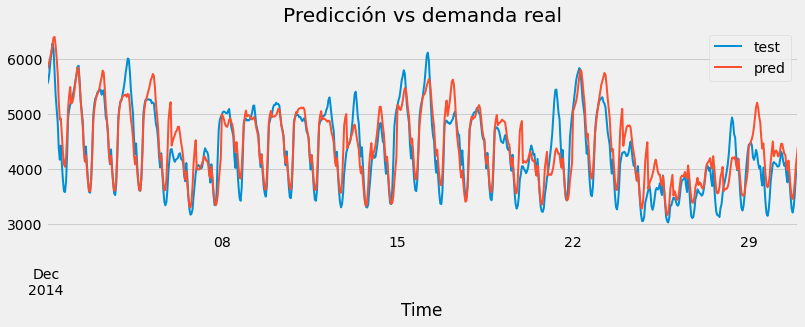

In [25]:
# Backtest modelo final
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos.Demand,
                            initial_train_size = len(datos[:fin_validacion]),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = False
                        )

fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [26]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

Error backtest: 251.93996461683977


Tras la optimización de lags e hiperparámetros, se ha conseguido reducir el error de predicción de 289.5 a 251.9.
<br><br>

### Intervalos de predicción
<br>

Un intervalo de predicción define el intervalo dentro del cual es de esperar que se encuentre el verdadero valor de $y$ con una determinada probabilidad. Por ejemplo, es de esperar que el intervalo de predicción (1, 99) contenga el verdadero valor de la predicción con un 98% de probabilidad.

Rob J Hyndman y George Athanasopoulos, listan en su libro *Forecasting: Principles and Practice* [mútiples formas de estimar intervalos de predicción](https://otexts.com/fpp3/prediction-intervals.html), la mayoría los cuales requieren que los resudios (errores) del modelo se distribuyan de forma normal. Cuando no se puede asumir esta propiedad, se puede recurrir a *bootstrapping*, que solo asume que los residuos no están correlacionados. Este es el método utilizado en la librería **skforecast** para los modelos de tipo `ForecasterAutoreg` y `ForecasterAutoregCustom`.
<br><br>

In [27]:
# Backtest del conjunto de test con intervalos de predicción
# ==============================================================================
metric, predicciones = backtesting_forecaster(
                            forecaster          = forecaster,
                            y                   = datos.Demand,
                            initial_train_size  = len(datos.Demand[:fin_validacion]),
                            fixed_train_size    = False,
                            steps               = 24,
                            metric              = 'mean_absolute_error',
                            interval            = [10, 90],
                            n_boot              = 500,
                            in_sample_residuals = True,
                            verbose             = False
                       )

print('Métrica backtesting:', metric)
predicciones.head(5)

Métrica backtesting: 251.93996461683977


,pred,lower_bound,upper_bound
2014-12-01 00:00:00,5727.876561,5598.911947,5849.678211
2014-12-01 01:00:00,5802.876139,5599.270390,5974.888764
2014-12-01 02:00:00,5880.047528,5619.841591,6113.916977
2014-12-01 03:00:00,5953.541637,5657.437015,6240.035968
2014-12-01 04:00:00,6048.740321,5697.793533,6343.068708


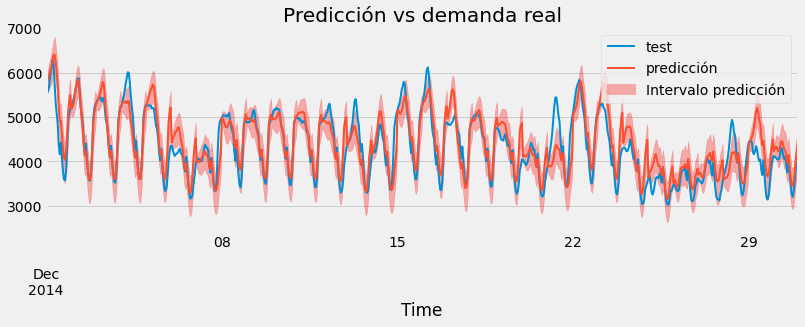

In [28]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones['pred'].plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    alpha = 0.3,
    color = 'red',
    label = 'Intervalo predicción' 
)
ax.legend();

In [29]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                     (datos.loc[fin_validacion:, 'Demand'] >= predicciones['lower_bound']) & \
                     (datos.loc[fin_validacion:, 'Demand'] <= predicciones['upper_bound']),
                     True,
                     False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {round(100*cobertura, 2)} %")

Cobertura del intervalo predicho: 79.03 %


El intervalo predicho tiene una cobertura inferior a la que cabría esperar (80%). Esto puede deberse al error marcadamente elevado que comete el modelo para los días 21, 24 y 25. Estos días están dentro del periodo vacacional de navidad, que suele caracterizarse por un comportamiento de consumo distinto al resto del mes.

### Predicción diaria anticipada
<br>

En el apartado anterior, se evaluó el modelo asumiendo que las predicciones del día siguiente se ejecutan justo al final del día anterior. En la práctica, esto no resulta muy útil ya que, para las primeras horas del día, apenas se dispone de anticipación.

Supóngase ahora que, para poder tener suficiente margen de acción, a las 11:00 horas de cada día se tienen que generar las predicciones del día siguiente. Es decir, a las 11:00 del dia $D$ se tienen que predecir las horas [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] de ese mismo día, y las horas [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] del día $D+1$. Esto implica que se tienen que predecir un total de 36 horas a futuro. 

El proceso de *backtesting* adaptado a este escenario es:

1. A las 11:00h del primer día del conjunto de test, se predicen las 36 siguientes horas (las 12 horas que quedan del día más las 24 horas de el día siguiente).

2. Se almacenan solo las predicciones del día siguiente, es decir, de la posición 12 en adelante.

3. Se añaden los datos de test hasta las 11:00 del día siguiente.

4. Se repite el proceso.

De esta forma, a las 11:00h de cada día, el modelo tiene acceso a los valores reales de demanda registrados hasta ese momento.

Este proceso puede realizarse fácilmente con el método `predict()` de un objeto `ForecasterAutoreg`. Si no se le indica nada, la predicción se inicia después del último valor de entrenamiento, pero, si se le especifica el argumento `last_window`, utiliza estos valores como punto de partida.

In [30]:
def backtest_predict_next_24h(forecaster, y, hour_init_prediction, exog=None,
                              verbose=False):
    
    '''
    Backtest ForecasterAutoreg object when predicting 24 hours of day D+1
    statring at specific hour of day D.
    
    Parameters
    ----------
    forecaster : ForecasterAutoreg 
        ForecasterAutoreg object already trained.
        
    y : pd.Series with datetime index sorted
        Test time series values. 
        
    exog : pd.Series or pd.Dataframe with datetime index sorted
        Test values of exogen variable. 
    
    hour_init_prediction: int 
        Hour of day D to start predicciones of day D+1.


    Returns 
    -------
    predicciones: pd.Series
        Value of predicciones.

    '''
    
    y = y.sort_index()
    if exog is not None:
        exog = exog.sort_index()
        
    dummy_steps = 24 - (hour_init_prediction + 1)
    steps = dummy_steps + 24
    
    # First position of `hour_init_prediction` in the series where there is enough
    # previous window to calculate lags.
    for datetime in y.index[y.index.hour == hour_init_prediction]:
        if len(y[:datetime]) >= len(forecaster.last_window):
            datetime_init_backtest = datetime
            print(f"Backtesting starts at day: {datetime_init_backtest}")
            break
    
    days_backtest = np.unique(y[datetime_init_backtest:].index.date)
    days_backtest = pd.to_datetime(days_backtest)
    days_backtest = days_backtest[1:]
    print(f"Days predicted in the backtesting: {days_backtest.strftime('%Y-%m-%d').values}")
    print('')
    backtest_predicciones = []
    
    for i, day in enumerate(days_backtest):        
        # Start and end of the last window used to create the lags
        end_window = (day - pd.Timedelta(1, unit='day')).replace(hour=hour_init_prediction)
        start_window = end_window - pd.Timedelta(forecaster.max_lag, unit='hour')
        last_window = y.loc[start_window:end_window]
               
        if exog is None:
            if verbose:
                print(f"Forecasting day {day.strftime('%Y-%m-%d')}")
                print(f"Using window from {start_window} to {end_window}")
                
            pred = forecaster.predict(steps=steps, last_window=last_window)
            
        else:
            start_exog_window = end_window + pd.Timedelta(1, unit='hour')
            end_exog_window   = end_window + pd.Timedelta(steps, unit='hour')
            exog_window = exog.loc[start_exog_window:end_exog_window]
            exog_window = exog_window
            
            if verbose:
                print(f"Forecasting day {day.strftime('%Y-%m-%d')}")
                print(f"    Using window from {start_window} to {end_window}")
                print(f"    Using exogen variable from {start_exog_window} to {end_exog_window}")
            
            pred = forecaster.predict(steps=steps, last_window=last_window, exog=exog_window)

        # Only store predicciones of day D+1
        pred = pred[dummy_steps:]
        backtest_predicciones.append(pred)
    
    backtest_predicciones = np.concatenate(backtest_predicciones)
    # Add datetime index
    backtest_predicciones = pd.Series(
                             data  = backtest_predicciones,
                             index = pd.date_range(
                                        start = days_backtest[0],
                                        end   = days_backtest[-1].replace(hour=23),
                                        freq  = 'h'
                                    )
                           )
    
    return backtest_predicciones

In [31]:
# Backtest
# ==============================================================================
predicciones = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = datos.loc[fin_validacion:, 'Demand'],
                    hour_init_prediction = 11,
                    verbose    = False
                )

Backtesting starts at day: 2014-12-03 11:00:00
Days predicted in the backtesting: ['2014-12-04' '2014-12-05' '2014-12-06' '2014-12-07' '2014-12-08'
 '2014-12-09' '2014-12-10' '2014-12-11' '2014-12-12' '2014-12-13'
 '2014-12-14' '2014-12-15' '2014-12-16' '2014-12-17' '2014-12-18'
 '2014-12-19' '2014-12-20' '2014-12-21' '2014-12-22' '2014-12-23'
 '2014-12-24' '2014-12-25' '2014-12-26' '2014-12-27' '2014-12-28'
 '2014-12-29' '2014-12-30']



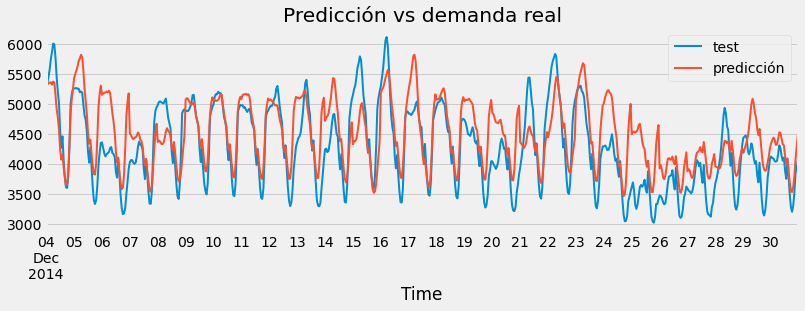

In [32]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [33]:
# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demand'],
            y_pred = predicciones
        )
print(f"Error de backtest: {error}")

Error de backtest: 394.53093960831126


Como era de esperar, al aumentar el horizonte de predicción de 24 a 36 horas, también lo hace el error de las predicciones.

### Importancia predictores
<br>

Dado que el objeto `ForecasterAutoreg` utiliza modelos *scikit-learn*, una vez entrenado, se puede acceder a la importancia de los predictores. Cuando el regresor empleado es un `LinearRegression()`, `Lasso()` o `Ridge()`, la importancia queda reflejada en los [coeficientes](https://www.cienciadedatos.net/documentos/py10-regresion-lineal-python.html#Interpretaci%C3%B3n-del-modelo) del modelo. En regresores  `GradientBoostingRegressor()` o `RandomForestRegressor()`, la importancia de los predictores está basada en la [reducción de impureza](https://www.cienciadedatos.net/documentos/py08_random_forest_python.html#Importancia-de-los-predictores).

*Nota: el método `get_feature_importance()` solo devuelve valores si el regresor utilizado dentro del forecaster tiene el atributo `coef_` o `feature_importances_`.*

In [34]:
# Importancia predictores
# ==============================================================================
forecaster.get_feature_importance()

,feature,importance
0,lag_1,896.658006
1,lag_2,-15.584447
2,lag_3,-63.083772
3,lag_23,127.523436
4,lag_24,307.323720
5,lag_25,-411.493066
6,lag_47,-50.359102
7,lag_48,248.273107
8,lag_49,-190.057733


<br>

## Forecasting con variables exógenas
<br>

En el ejemplo anterior, se han utilizado como predictores únicamente lags de la propia variable objetivo. En ciertos escenarios, es posible disponer de información sobre otras variables, **cuyo valor a futuro se conoce**, y que pueden servir como predictores adicionales en el modelo. Algunos ejemplos típicos son:

+ Festivos (local, nacional...)

+ Mes del año

+ Día de la semana

+ Hora del día

En este caso de uso, el análisis gráfico mostraba evidencias de que, los días festivos, la demanda es menor. Si un día es festivo o no, puede saberse a futuro, por lo que se puede emplear como variable exógena. Véase cómo afecta al modelo si se incluye como predictor la variable *Holiday* disponible en el set de datos.

### Entrenamiento del Forecaster
<br>

Se emplean los hiperparámetros y lags identificados como óptimos en el apartado anterior.

In [35]:
# Se convierte la columna Holiday de boolean a integer
datos.loc[:,'Holiday'] = datos['Holiday'].astype(int)
datos_train.loc[:,'Holiday'] = datos_train['Holiday'].astype(int)
datos_test.loc[:,'Holiday'] = datos_test['Holiday'].astype(int)

In [36]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge(alpha=215.44)),
                lags      = [1, 2, 3, 23, 24, 25, 47, 48, 49],
             )

forecaster.fit(y=datos.Demand[:fin_validacion], exog=datos.Holiday[:fin_validacion])
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=215.44))]) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Window size: 49 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: Holiday 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 215.44, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-04-03 22:11:24 
Last fit date: 2022-04-03 22:11:24 
Skforecast version: 0.4.3 

### Predicción diaria anticipada
<br>

Se repite de nuevo el proceso de *backtesting* en el que, a las 11:00 horas de cada día, se tienen que obtener las predicciones del día siguiente. Esta vez, incluyendo como predictor si el día es festivo o no.

In [37]:
# Backtest
# ==============================================================================
predicciones = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = datos.loc[fin_validacion:, 'Demand'],
                    exog       = datos.loc[fin_validacion:, 'Holiday'],
                    hour_init_prediction = 11,
                    verbose    = False
               )

Backtesting starts at day: 2014-12-03 11:00:00
Days predicted in the backtesting: ['2014-12-04' '2014-12-05' '2014-12-06' '2014-12-07' '2014-12-08'
 '2014-12-09' '2014-12-10' '2014-12-11' '2014-12-12' '2014-12-13'
 '2014-12-14' '2014-12-15' '2014-12-16' '2014-12-17' '2014-12-18'
 '2014-12-19' '2014-12-20' '2014-12-21' '2014-12-22' '2014-12-23'
 '2014-12-24' '2014-12-25' '2014-12-26' '2014-12-27' '2014-12-28'
 '2014-12-29' '2014-12-30']



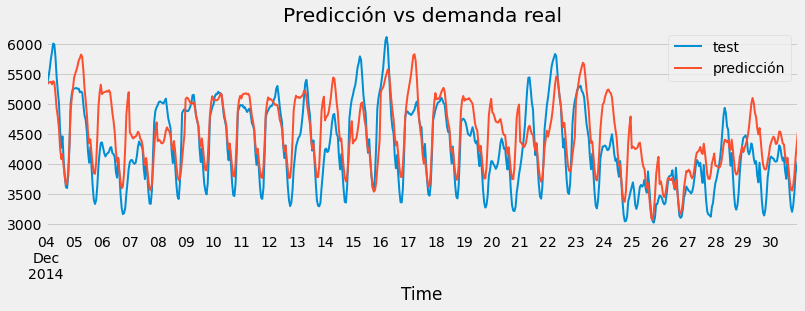

In [38]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [39]:
# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demand'],
            y_pred = predicciones
        )

print(f"Error de backtest: {error}")

Error de backtest: 375.1740344328162


Utilizando como variable exógena si el día es festivo o no, se consigue reducir ligeramente el error de predicción de 394.5 a 375.1. Véase qué ocurre al añadir, además de si el día anterior y siguiente son festivos, el día de la semana y hora del día.

In [40]:
# Creación de nuevas variables exógenas
# ==============================================================================
# Al ser datos  horarios y empezar a las 00:00 se tienen que desplazar los valores
# de 24 en 24.
datos.loc[:,'Holiday_day_before'] = datos['Holiday'].shift(24)
datos.loc[:,'Holiday_next_day']   = datos['Holiday'].shift(-24)
datos=datos.dropna()

# One hot encoding del día de la semana y la hora del día
datos=pd.get_dummies(datos, columns=['dia_semana', 'hora_dia'])
datos.head(3)

,Demand,Temperature,Holiday,mes,Holiday_day_before,Holiday_next_day,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,...,hora_dia_15,hora_dia_16,hora_dia_17,hora_dia_18,hora_dia_19,hora_dia_20,hora_dia_21,hora_dia_22,hora_dia_23,hora_dia_24
Time,,,,,,,,,,,,,,,,,,,,,
2012-01-02 00:00:00,5262.895338,32.825,1,1,1.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-01-02 01:00:00,5786.043417,34.500,1,1,1.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-01-02 02:00:00,6236.144167,36.725,1,1,1.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge(alpha=215.44)),
                lags      = [1, 2, 3, 23, 24, 25, 47, 48, 49],
             )

exog = [column for column in datos.columns if column.startswith(('dia', 'hora', 'Holiday'))]
forecaster.fit(y=datos.Demand[: fin_validacion], exog=datos[exog][: fin_validacion])

# Backtest
# ==============================================================================
predicciones = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = datos.loc[fin_validacion:, 'Demand'],
                    exog       = datos.loc[fin_validacion:, exog],
                    hour_init_prediction = 11,
                    verbose    = False
               )

# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demand'],
            y_pred = predicciones
        )

print(f"Error de backtest: {error}")

Backtesting starts at day: 2014-12-03 11:00:00
Days predicted in the backtesting: ['2014-12-04' '2014-12-05' '2014-12-06' '2014-12-07' '2014-12-08'
 '2014-12-09' '2014-12-10' '2014-12-11' '2014-12-12' '2014-12-13'
 '2014-12-14' '2014-12-15' '2014-12-16' '2014-12-17' '2014-12-18'
 '2014-12-19' '2014-12-20' '2014-12-21' '2014-12-22' '2014-12-23'
 '2014-12-24' '2014-12-25' '2014-12-26' '2014-12-27' '2014-12-28'
 '2014-12-29']

Error de backtest: 311.3332381487053


Con los nuevos predictores se consigue reducir todavía más el error del modelo.

### Incluir temperatura como predictor
<br>

Dado que en el set de datos también se dispone de la temperatura, y esta está relacionada con la demanda, podría ser tentador incorporarla como predictor. Sin embargo, esta aproximación **no sería correcta** ya que, la temperatura no se conoce a futuro. Sí es posible utilizar la previsión de tempratura como un predictor del modelo pero, en tal caso, durante el entrenamiento habría que utilizar la previsión que había en ese momento, no la temperatura real.
<br><br>

## Modelo direct multi-step
<br>

Los modelos `ForecasterAutoreg` siguen una estrategia de predicción recursiva en la que, cada nueva predicción, se basa en la predicción anterior. Una alternativa es entrenar un modelo para cada uno de los *steps* que se desea predecir, lo que se conoce como *direct multi-step forecasting*. Si bien es computacionalmente más costosa que la recursiva, puesto que requiere entrenar múltiples modelos, en algunos escenarios, consigue mejores resultados. Este tipo de modelos pueden obtenerse con la clase `ForecasterAutoregMultiOutput` y pueden incluir también una o múltiples variables exógenas.

### Entrenamiento y *tuning* del Forecaster
<br>

A diferencia de cuando se utiliza `ForecasterAutoreg`, en los modelos de tipo `ForecasterAutoregMultiOutput` hay que indicar, en el momento de su creación, el número máximo de *steps* que se quieren predecir.

In [42]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                regressor = LGBMRegressor(max_depth=4),
                steps     = 36,
                lags      = 24 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [[1, 2, 3, 23, 24], [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [4, 6]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos.loc[:fin_validacion, 'Demand'],
                        exog               = datos.loc[:fin_validacion, exog],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        metric             = 'mean_absolute_error',
                        refit              = False,
                        initial_train_size = len(datos.loc[:fin_train]),
                        return_best        = True,
                        verbose            = False
                  )

Number of models compared: 8


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [01:14<00:00, 37.34s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'max_depth': 6, 'n_estimators': 500}
  Backtesting metric: 237.27478811428122



### Predicción diaria anticipada
<br>

Se repite de nuevo el proceso de *backtesting* en el que, a las 11:00 horas de cada día, se tienen que obtener las predicciones del día siguiente. Esta vez, incluyendo como predictores las variables exógenas.

In [43]:
# Backtest
# ==============================================================================
predicciones = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = datos.loc[fin_validacion:, 'Demand'],
                    exog       = datos.loc[fin_validacion:, exog],
                    hour_init_prediction = 11,
                    verbose    = False
               )

Backtesting starts at day: 2014-12-03 11:00:00
Days predicted in the backtesting: ['2014-12-04' '2014-12-05' '2014-12-06' '2014-12-07' '2014-12-08'
 '2014-12-09' '2014-12-10' '2014-12-11' '2014-12-12' '2014-12-13'
 '2014-12-14' '2014-12-15' '2014-12-16' '2014-12-17' '2014-12-18'
 '2014-12-19' '2014-12-20' '2014-12-21' '2014-12-22' '2014-12-23'
 '2014-12-24' '2014-12-25' '2014-12-26' '2014-12-27' '2014-12-28'
 '2014-12-29']



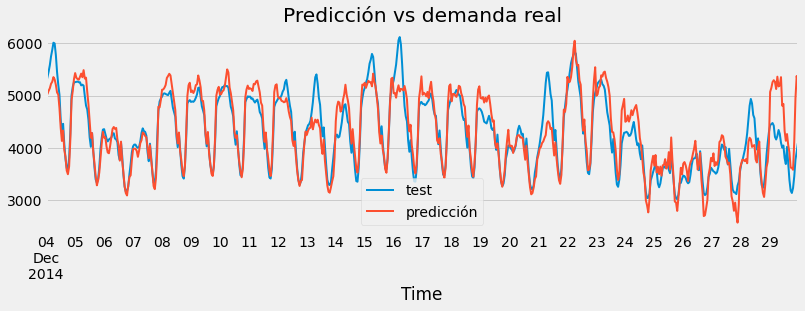

In [44]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [45]:
# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demand'],
            y_pred = predicciones
        )

print(f"Error de backtest: {error}")

Error de backtest: 228.22743242039024


En este caso, empleando un modelo gradient boosting (LGBMRegressor), la estrategia *direct multi-step* genera mejores resultados que la estrategia recursiva.

## Información de sesión

In [46]:
import session_info
session_info.show(html=False)

-----
lightgbm            3.3.1
matplotlib          3.4.3
numpy               1.21.5
pandas              1.3.0
seaborn             0.11.2
session_info        1.0.0
skforecast          0.4.3
sklearn             1.0.1
statsmodels         0.13.0
-----
IPython             7.27.0
jupyter_client      6.1.12
jupyter_core        4.7.1
jupyterlab          3.1.11
notebook            6.3.0
-----
Python 3.7.10 (default, Feb 26 2021, 18:47:35) [GCC 7.3.0]
Linux-5.13.0-37-generic-x86_64-with-debian-bullseye-sid
-----
Session information updated at 2022-04-03 22:13


## Bibliografía
<br>

Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. [libro](https://otexts.com/fpp3/)

Time Series Analysis and Forecasting with ADAM Ivan Svetunkov [libro](https://openforecast.org/adam/)

Python Data Science Handbook by Jake VanderPlas [libro](https://www.amazon.es/gp/product/1491912057/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1491912057&linkId=73620d22f9d4a0a76d27592dabf13c83)

Python for Finance: Mastering Data-Driven Finance [libro](https://www.amazon.es/gp/product/1492024333/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1492024333&linkId=70c3175ad015970cd1c2328b7a40a055)

**¿Cómo citar este documento?**

<p style="text-align:left"><font size="3" color="#555">
Predicción (<i>forecasting</i>) de la demanda eléctrica con Python by Joaquín Amat Rodrigo, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/py29-forecasting-demanda-energia-electrica-python.html
    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by  Joaquín Amat Rodrigo is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.